In [ ]:
#import librarys

from keras import backend as K
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from numpy import array, hstack
from keras.models import Sequential, Model
from keras.layers import Flatten, Conv1D, MaxPooling1D, Activation, Input, BatchNormalization, Embedding, GlobalMaxPooling1D, AveragePooling1D, Dense, LSTM, Dropout, Input, LayerNormalization
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.engine.input_layer import Input
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import pywt
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping

## Import stock data  

[*********************100%***********************]  1 of 1 completed


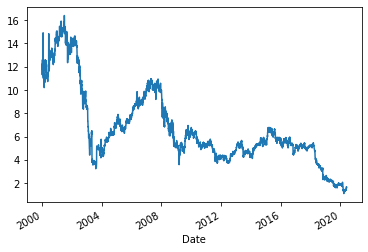

In [ ]:
data = yf.download('AMP.AX','2000-01-01','2020-05-30')
stockdata = data.values

# Plot the close price of the AAPL
data['Close'].plot()
plt.show()

##Scale the data
Here the data will be scaled so as to not overload the model's trained weights on any individual variable due to inconsistent scales.

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))
data_scaled = scaler.fit_transform(data.values)
data_scaled.shape

(5200, 6)

##Principal Components Analysis
Next I will reduce the dimensionality of the dataset through principal components.

In [ ]:
pca = PCA()
pca.fit(data_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

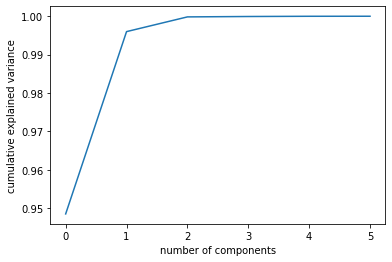

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

It makes sense that principal components analysis suggests that 2 components are needed to explain all of the variance as there are essentially two categorys of variables - price and volume. The two components have summarised these two pieces of information. Lets create the components.

In [ ]:
num_components = 2
pca = PCA(num_components)  
transformeddata = pca.fit_transform(data_scaled)


In [ ]:
transformeddata.shape

(5200, 2)

##Wavelet transformations
Here I will attempt to denoise some of the data using wavelet transformations.


In [ ]:
WAVELET = "haar"
LEVEL = 2 

signal1 = transformeddata[:,0]

coeffs = pywt.wavedec(signal1, WAVELET, level=LEVEL)
threshold = 1
coeffs[1:] = (pywt.threshold(i, value=threshold, mode="soft" ) for i in coeffs[1:])
reconstructed_signal1 = pywt.waverec(coeffs, WAVELET)


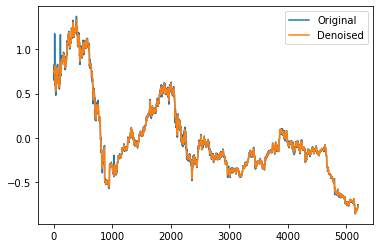

In [ ]:
plt.plot(signal1, label="Original", zorder=1)
plt.plot(reconstructed_signal1, label="Denoised", zorder=10)

plt.legend()
plt.show()

In [ ]:
signal2 = transformeddata[:-1,1]

coeffs = pywt.wavedec(signal2, WAVELET, level=LEVEL)
threshold = 1
coeffs[1:] = (pywt.threshold(i, value=threshold, mode="soft" ) for i in coeffs[1:])
reconstructed_signal2 = pywt.waverec(coeffs, WAVELET)

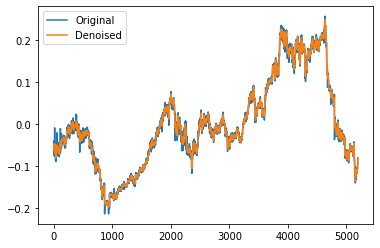

In [ ]:
plt.plot(signal2, label="Original", zorder=1)
plt.plot(reconstructed_signal2, label="Denoised", zorder=10)
plt.legend()
plt.show()

In [ ]:
reconstructed_signal1 = reconstructed_signal1.reshape((len(reconstructed_signal1), 1))
reconstructed_signal2 = reconstructed_signal2.reshape((len(reconstructed_signal2), 1))
wavelet = hstack((reconstructed_signal1, reconstructed_signal2))
wavelet.shape

(5200, 2)

These graphs show that the variability of each of the components has been reduced.

## Prepare the data
Here I will create some data generators that will massage the array like data into a shape that will allow for predictions on a set number of past days.

In [ ]:
past_days = 60
test_split_at = len(data) - 100 - past_days # test on the last 100 days



trainingwave = wavelet[:test_split_at,]
training = transformeddata[:test_split_at,]
val_split = round(len(training)*0.8)

component1tr = training[:,0]
component2tr = training[:,1]
component1tr = component1tr.reshape((len(component1tr), 1))
component2tr = component2tr.reshape((len(component2tr), 1))
# horizontally stack columns
datasettr = hstack((component1tr, component2tr))

generatortrain = TimeseriesGenerator(datasettr, data_scaled[:test_split_at,0], length=past_days, batch_size=1, end_index=val_split)
generatortrainwave = TimeseriesGenerator(trainingwave, data_scaled[:test_split_at,0], length=past_days, batch_size=1, end_index=val_split)
generatorval = TimeseriesGenerator(datasettr, data_scaled[:test_split_at,0], length=past_days, batch_size=1, start_index=val_split)
generatorvalwave = TimeseriesGenerator(trainingwave, data_scaled[:test_split_at,0], length=past_days, batch_size=1, start_index=val_split)


In [ ]:
testing = transformeddata[test_split_at:,]
testingwave = wavelet[test_split_at:,]

component1te = testing[:,0]
component2te = testing[:,1]
component1te = component1te.reshape((len(component1te), 1))
component2te = component2te.reshape((len(component2te), 1))
# horizontally stack columns
datasette = hstack((component1te, component2te))

generatortest = TimeseriesGenerator(datasette, data_scaled[test_split_at:,0], length=past_days, batch_size=1)
generatortestwave = TimeseriesGenerator(testingwave, data_scaled[test_split_at:,0], length=past_days, batch_size=1)


##Visualisation
Here I define a function that will plot validation loss against training loss. It will also identify peak loss and which epoch this occurs at

In [ ]:
def plotgraphs(fit, epoch):
    loss = fit.history['loss']
    val_loss = fit.history['val_loss']
    
    minloss = min(loss)
    minvalloss = min(val_loss)
    lossepoch = loss.index(minloss)+1
    vallossepoch = val_loss.index(minvalloss)+1

    epochs = range(1, epoch+1)
    
    plt.text(1.2, 1, print ('Minima of training/validation loss occurs at', minloss,'/' , minvalloss,'respectively and this occurs at epochs', lossepoch,'/',vallossepoch, 'respectively.'))
    plt.plot(epochs, val_loss, 'b+', label='Validation')
    plt.plot(epochs, loss, 'r+', label='Training')
    plt.xlabel('Epochs')
    plt.ylabel('Validation and Training Loss')
    plt.legend()

    plt.show()



##Naieve Estimate
Here I will develop a naieve estimartor where the prediction for tommorows closing price is todays closing price.


In [ ]:
import numpy as np
pred = np.array(0)
label = np.array(0)
for i in range(1, len(stockdata)):
  pred = np.append(pred,stockdata[i-1,0])
  label = np.append(label,stockdata[i,0])
  
 

In [ ]:
mean_squared_error(label,pred)

0.024886800319393738

##Callbacks
As identified in the literature review, this callback will ensure that the optimal weights are saved and will stop the training process once validation loss has stopped decreasing for 10 epochs.

In [ ]:
earlystop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

##Past days testing
Here I will trial some different values for the number of previous days trained on.

Minima of training/validation loss occurs at 8.280649490188807e-05 / 2.485680306563154e-05 respectively and this occurs at epochs 9 / 5 respectively.


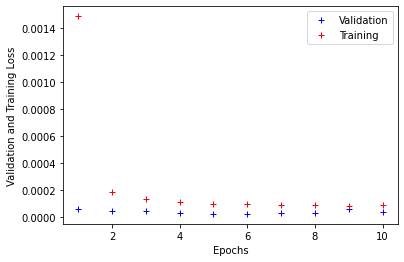

Minima of training/validation loss occurs at 8.669460657984018e-05 / 8.156293006322812e-06 respectively and this occurs at epochs 9 / 7 respectively.


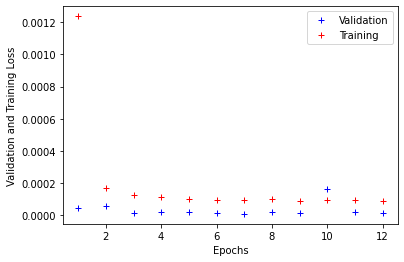

Minima of training/validation loss occurs at 9.172000864055008e-05 / 1.0033114449470304e-05 respectively and this occurs at epochs 11 / 6 respectively.


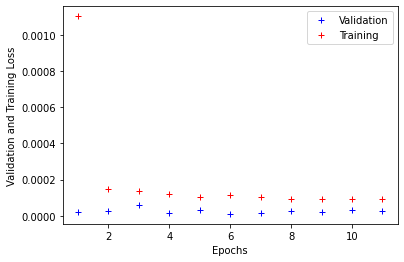

Minima of training/validation loss occurs at 9.496548591414467e-05 / 9.860553291218821e-06 respectively and this occurs at epochs 10 / 5 respectively.


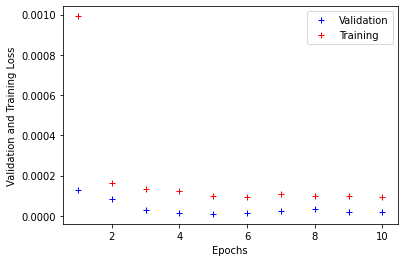

Minima of training/validation loss occurs at 0.00010288305202266201 / 1.5185848496912513e-05 respectively and this occurs at epochs 8 / 3 respectively.


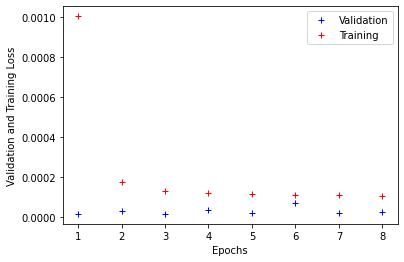

Minima of training/validation loss occurs at 9.987324301619083e-05 / 8.610872100689448e-06 respectively and this occurs at epochs 8 / 5 respectively.


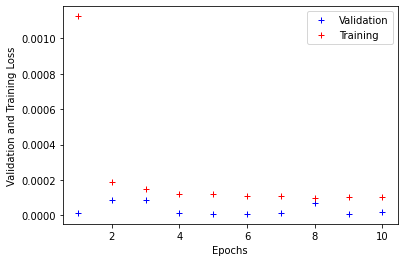

In [ ]:
trials = [10,25,50,60,70,100]

for i in trials:
  trialgen = TimeseriesGenerator(datasettr, data_scaled[:test_split_at,0], length=i, batch_size=1, end_index=val_split)
  lstm = Sequential()
  lstm.add(Input(shape=(i, 2)))
  lstm.add(LSTM(units=i))
  lstm.add(Dense(units = 1))

  lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')
  LstmHist = lstm.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
  epochs=len(LstmHist.epoch)
  plotgraphs(LstmHist, epochs)



It seems that changing this metric does not change the models ability to predict stock price. i will stick with past_days=60.

## Build a Long Short Term Memory model
I will start with a basic, very large model with informed architechture choices from the literature review. We will keep nodes in the LSTM constant, use the adam optimiser and begin with 2 layers. and purposefully overfit.


Things to try:
deep wide
peepholde lstm
bidirectional lstm

In [ ]:

lstm = Sequential()
lstm.add(Input(shape=(past_days, 2)))
lstm.add(LSTM(units=512, return_sequences=True))
lstm.add(LSTM(units=512))
lstm.add(Dense(units = 1))

lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 6.916769780218601e-05 / 5.434406557469629e-05 respectively and this occurs at epochs 94 / 2 respectively.


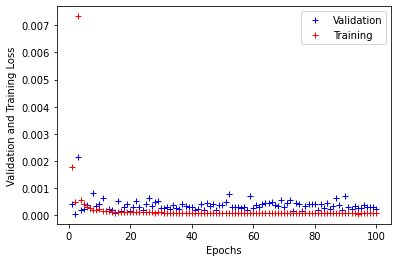

In [ ]:
LstmHist = lstm.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0)
epochs=len(LstmHist.epoch)
plotgraphs(LstmHist, epochs)

This has clearly very early overfit with no late surges in min val loss. Lets start addressing this overfitting by reducing neurons.

In [ ]:

lstm = Sequential()
lstm.add(Input(shape=(past_days, 2)))
lstm.add(LSTM(units=past_days, return_sequences=True))
lstm.add(LSTM(units=past_days))
lstm.add(Dense(units = 1))

lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 0.00011079385876655579 / 8.273328603536356e-06 respectively and this occurs at epochs 10 / 6 respectively.


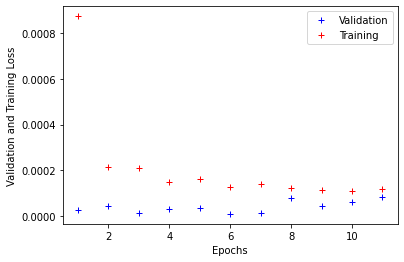

In [ ]:
LstmHist = lstm.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(LstmHist.epoch)
plotgraphs(LstmHist, epochs)

This has massively increased peak minimum loss. It may even be underfitting a little.

In [ ]:
lstm.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 60, 60)            15120     
_________________________________________________________________
lstm_13 (LSTM)               (None, 60)                29040     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 61        
Total params: 44,221
Trainable params: 44,221
Non-trainable params: 0
_________________________________________________________________


Perhaps some dense nodes are required? The lstm layer jumps from 29040 parameters to 61 parameters in the dense layer.

In [ ]:

lstm = Sequential()
lstm.add(Input(shape=(past_days, 2)))
lstm.add(LSTM(units=past_days, return_sequences=True))
lstm.add(LSTM(units=past_days))
lstm.add(Dense(units = 16))
lstm.add(Dense(units = 1))

lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 0.00014847962302155793 / 1.8969603843288496e-05 respectively and this occurs at epochs 5 / 2 respectively.


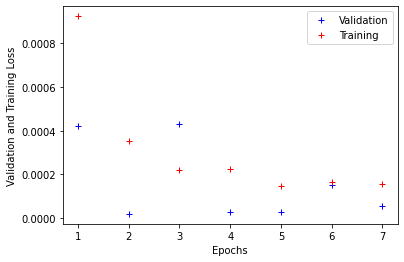

In [ ]:
LstmHist = lstm.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(LstmHist.epoch)
plotgraphs(LstmHist, epochs)

In [ ]:
lstm.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 60, 60)            15120     
_________________________________________________________________
lstm_15 (LSTM)               (None, 60)                29040     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                976       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 45,153
Trainable params: 45,153
Non-trainable params: 0
_________________________________________________________________


This has decreased min val loss and decreased the models ability to generalise. Next lets try instead increasing the lstm parameters.

In [ ]:

lstm = Sequential()
lstm.add(Input(shape=(past_days, 2)))
lstm.add(LSTM(units=2*past_days, return_sequences=True))
lstm.add(LSTM(units=2*past_days))
lstm.add(Dense(units = 1))

lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 0.0001331001112703234 / 8.859164154273458e-06 respectively and this occurs at epochs 7 / 3 respectively.


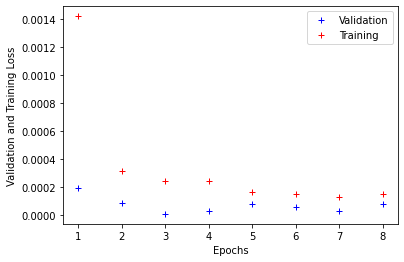

In [ ]:
LstmHist = lstm.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(LstmHist.epoch)
plotgraphs(LstmHist, epochs)

This has not solved the apparent lower validation accuracy over training accuracy and yet it is twice a large model. Therefore I will revert to past_days nodes. Maybe another layer is needed?

In [ ]:

lstm = Sequential()
lstm.add(Input(shape=(past_days, 2)))
lstm.add(LSTM(units=past_days, return_sequences=True))
lstm.add(LSTM(units=past_days, return_sequences=True))
lstm.add(LSTM(units=past_days))
lstm.add(Dense(units = 1))

lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 0.00013081713404972106 / 9.909330401569605e-06 respectively and this occurs at epochs 9 / 4 respectively.


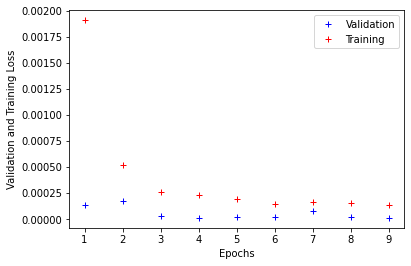

In [ ]:
LstmHist = lstm.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(LstmHist.epoch)
plotgraphs(LstmHist, epochs)

In [ ]:
lstm.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 60, 60)            15120     
_________________________________________________________________
lstm_28 (LSTM)               (None, 60, 60)            29040     
_________________________________________________________________
lstm_29 (LSTM)               (None, 60)                29040     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 61        
Total params: 73,261
Trainable params: 73,261
Non-trainable params: 0
_________________________________________________________________


This has increased model complexity without an increase in generalisation or predictive ability. Lets start to investigate some other generalisation techniques.

Lets start trying to increase the generalisation of the model. First lets try l2 regularisers.


In [ ]:

lstm = Sequential()
lstm.add(Input(shape=(past_days, 2)))
lstm.add(LSTM(units=past_days, return_sequences=True, recurrent_regularizer=regularizers.l1_l2(l1=0, l2=0.0001)))
lstm.add(LSTM(units=past_days, recurrent_regularizer=regularizers.l1_l2(l1=0, l2=0.0001)))
lstm.add(Dense(units = 1))

lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')


Minima of training/validation loss occurs at 0.00018400173576083034 / 6.871874211356044e-05 respectively and this occurs at epochs 12 / 7 respectively.


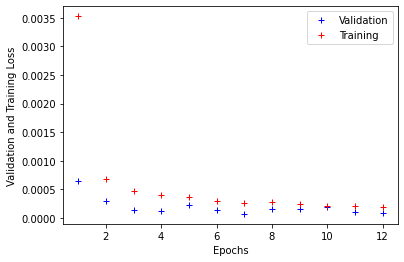

In [ ]:
LstmHist = lstm.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(LstmHist.epoch)
plotgraphs(LstmHist, epochs)

This seems to havehelped the model in generalising. Lets try l1

In [ ]:
lstm = Sequential()
lstm.add(Input(shape=(past_days, 2)))
lstm.add(LSTM(units=past_days, return_sequences=True, recurrent_regularizer=regularizers.l1_l2(l1=0.0001, l2=0)))
lstm.add(LSTM(units=past_days, recurrent_regularizer=regularizers.l1_l2(l1=0.0001, l2=0)))
lstm.add(Dense(units = 1))

lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')


Minima of training/validation loss occurs at 0.0005554307717829943 / 0.00037383753806352615 respectively and this occurs at epochs 13 / 8 respectively.


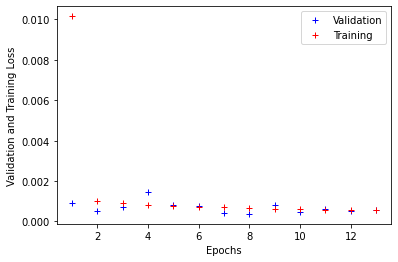

In [ ]:
LstmHist = lstm.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(LstmHist.epoch)
plotgraphs(LstmHist, epochs)

Okay, this has not helped. Next lets try dropout.

In [ ]:
lstm = Sequential()
lstm.add(Input(shape=(past_days, 2)))
lstm.add(LSTM(units=past_days,return_sequences=True, dropout=0.5))
lstm.add(LSTM(units=past_days, dropout=0.5))
lstm.add(Dense(units = 1))

lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 0.000568310497328639 / 0.0002018651575781405 respectively and this occurs at epochs 6 / 1 respectively.


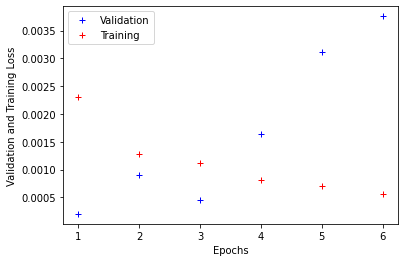

In [ ]:
LstmHist = lstm.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(LstmHist.epoch)
plotgraphs(LstmHist, epochs)

In [ ]:
lstm = Sequential()
lstm.add(Input(shape=(past_days, 2)))
lstm.add(LSTM(units=past_days,return_sequences=True, dropout=0.3))
lstm.add(LSTM(units=past_days, dropout=0.3))
lstm.add(Dense(units = 1))

lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 0.0004513297462835908 / 0.0008890378521755338 respectively and this occurs at epochs 10 / 1 respectively.


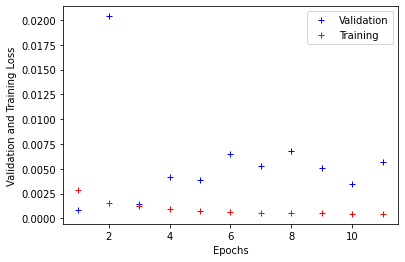

In [ ]:
LstmHist = lstm.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(LstmHist.epoch)
plotgraphs(LstmHist, epochs)

In [ ]:
lstm = Sequential()
lstm.add(Input(shape=(past_days, 2)))
lstm.add(LSTM(units=past_days,return_sequences=True))
lstm.add(Dropout(0.5))
lstm.add(LSTM(units=past_days))
lstm.add(Dropout(0.5))
lstm.add(Dense(units = 1))

lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 0.0010604595299810171 / 3.3916119718924165e-05 respectively and this occurs at epochs 64 / 30 respectively.


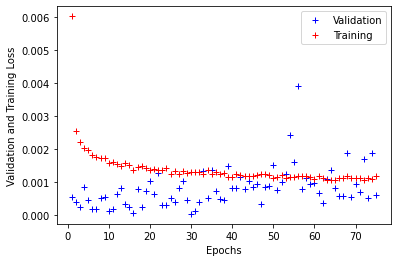

In [ ]:
LstmHist = lstm.fit(generatortrain, validation_data=generatorval, epochs = 75, verbose=0)
epochs=len(LstmHist.epoch)
plotgraphs(LstmHist, epochs)

In [ ]:
lstm = Sequential()
lstm.add(Input(shape=(past_days, 2)))
lstm.add(LSTM(units=past_days,return_sequences=True))
lstm.add(Dropout(0.3))
lstm.add(LSTM(units=past_days))
lstm.add(Dropout(0.3))
lstm.add(Dense(units = 1))

lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 0.0007151525933295488 / 2.8973034204682335e-05 respectively and this occurs at epochs 18 / 10 respectively.


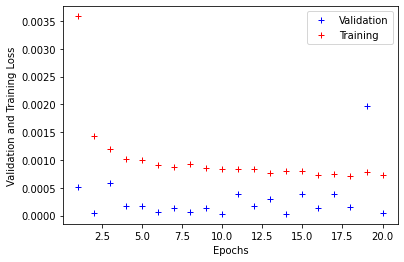

In [ ]:
LstmHist = lstm.fit(generatortrain, validation_data=generatorval, epochs = 75, verbose=0, callbacks=earlystop)
epochs=len(LstmHist.epoch)
plotgraphs(LstmHist, epochs)

Next lets try Layer Normalisation

In [ ]:
from keras.layers import LayerNormalization
lstm = Sequential()
lstm.add(Input(shape=(past_days, 2)))
lstm.add(LSTM(units=past_days, return_sequences=True))

lstm.add(LayerNormalization())

lstm.add(LSTM(units=past_days))

lstm.add(LayerNormalization())

lstm.add(Dense(units = 1))

lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 0.00020551880879793316 / 0.00023023097310215235 respectively and this occurs at epochs 18 / 8 respectively.


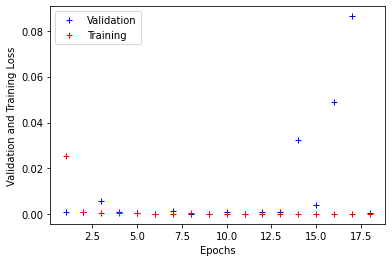

In [ ]:
LstmHist = lstm.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(LstmHist.epoch)
plotgraphs(LstmHist, epochs)

Okay this hasnt worked. Finally, lets investigate using the wavelet-transformed data.

In [ ]:
lstmw = Sequential()
lstmw.add(Input(shape=(past_days, 2)))
lstmw.add(LSTM(units=past_days, return_sequences=True))
lstmw.add(LSTM(units=past_days))
lstmw.add(Dense(units = 1))

lstmw.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 0.0001053478117682971 / 1.4969280528021045e-05 respectively and this occurs at epochs 15 / 5 respectively.


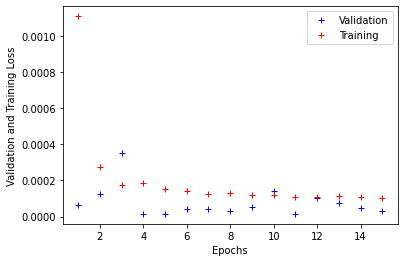

In [ ]:
LstmwHist = lstmw.fit(generatortrainwave, validation_data=generatorvalwave, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(LstmwHist.epoch)
plotgraphs(LstmwHist, epochs)

##Attention
The following resoruce defines a layer that will allow for attention implementation into keras's sequential API.

https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043

In [ ]:
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.engine.input_layer import Input
from keras import backend as K
from keras.models import Model

class Attention(Layer):

    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

Minima of training/validation loss occurs at 0.00047335578710772097 / 0.0001710204523988068 respectively and this occurs at epochs 20 / 10 respectively.


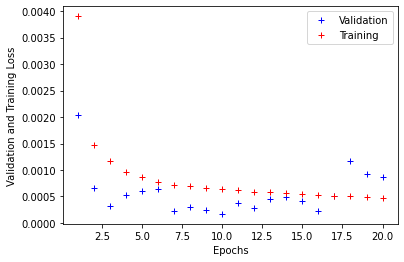

In [ ]:
attention = Sequential()
attention.add(Input(shape=(past_days, 2)))
attention.add(LSTM(units=past_days, recurrent_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), return_sequences=True))
attention.add(LSTM(units=past_days, recurrent_regularizer=regularizers.l1_l2(l1=0, l2=0.0001), return_sequences=True))
attention.add(Attention(past_days))

attention.add(Dense(units = 1))

attention.compile(optimizer = 'adam', loss = 'mean_squared_error')
attentionHist = attention.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(attentionHist.epoch)
plotgraphs(attentionHist, epochs)

In [ ]:
features_set = []
labels = []
for i in range(past_days, test_split_at):
    features_set.append(training[i-past_days:i, ])
    labels.append(data_scaled[i, [0]])
    
features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 2))

##Build a Convolutional Neural Network Model
As per my literature review, a 1D convolutional model has been shown to be useful for stock price prediction. I will begin by creating a large model and overfit as always.

In [ ]:
conv = Sequential()
conv.add(Input(shape=(past_days, 2)))
conv.add(Conv1D(filters=128, kernel_size=2 ,activation='relu'))
conv.add(AveragePooling1D(2))
conv.add(Conv1D(filters=64, kernel_size=2 , activation='relu'))
conv.add(AveragePooling1D(2))
conv.add(Flatten())
conv.add(Dense(1))

conv.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 0.00022051068663131446 / 0.0026226858608424664 respectively and this occurs at epochs 70 / 33 respectively.


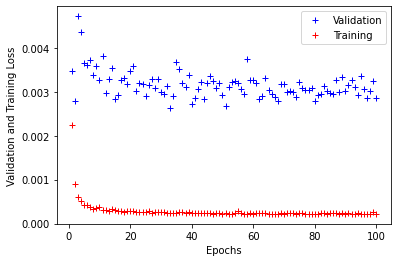

In [ ]:
convHist = conv.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0)
epochs=len(convHist.epoch)
plotgraphs(convHist, epochs)

Overfitting at epoch 1. I will try to address this with the best generalisation techniques I found in my previous paper. First lets optimise number of nodes.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Activation, Input, BatchNormalization, Embedding, GlobalMaxPooling1D, AveragePooling1D

conv = Sequential()
conv.add(Input(shape=(past_days, 2)))
conv.add(Conv1D(filters=64, kernel_size=2 ,activation='relu'))
conv.add(AveragePooling1D(2))
conv.add(Conv1D(filters=32, kernel_size=2 , activation='relu'))
conv.add(AveragePooling1D(2))
conv.add(Flatten())
conv.add(Dense(1))

conv.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 0.00029030011501163244 / 0.0026798907201737165 respectively and this occurs at epochs 12 / 2 respectively.


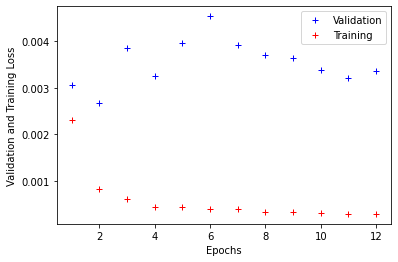

In [ ]:
convHist = conv.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(convHist.epoch)
plotgraphs(convHist, epochs)

Better but still too many nodes

In [ ]:
conv = Sequential()
conv.add(Input(shape=(past_days, 2)))
conv.add(Conv1D(filters=32, kernel_size=2 ,activation='relu'))
conv.add(AveragePooling1D(2))
conv.add(Conv1D(filters=16, kernel_size=2 , activation='relu'))
conv.add(Flatten())
conv.add(Dense(1))

conv.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 0.00029634087695740163 / 0.00036011417978443205 respectively and this occurs at epochs 11 / 1 respectively.


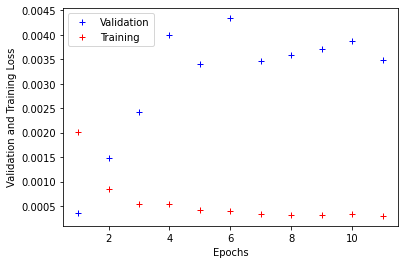

In [ ]:
convHist = conv.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(convHist.epoch)
plotgraphs(convHist, epochs)

This is even better, lets go again. 

In [ ]:
conv = Sequential()
conv.add(Input(shape=(past_days, 2)))
conv.add(Conv1D(filters=16, kernel_size=2 ,activation='relu'))
conv.add(AveragePooling1D(2))
conv.add(Conv1D(filters=8, kernel_size=2 , activation='relu'))
conv.add(Flatten())
conv.add(Dense(1))

conv.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 0.0002907010493800044 / 0.0027997319120913744 respectively and this occurs at epochs 11 / 1 respectively.


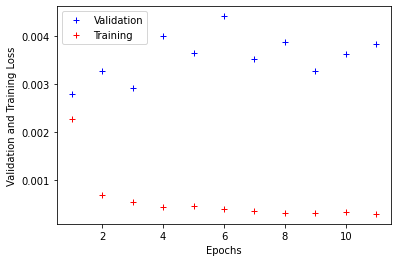

In [ ]:
convHist = conv.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(convHist.epoch)
plotgraphs(convHist, epochs)

This has not helped, min val loss has increased and the model seems to have decreased in generalisation. Okay lets stick with 32-16. Now lets try some regularisation techniques. First, Layer Normalisation.

In [ ]:
conv = Sequential()
conv.add(Input(shape=(past_days, 2)))
conv.add(Conv1D(filters=32, kernel_size=2 ,activation='relu'))

conv.add(AveragePooling1D(2))
conv.add(LayerNormalization())

conv.add(Conv1D(filters=16, kernel_size=2 , activation='relu'))

conv.add(AveragePooling1D(2))
conv.add(LayerNormalization())
conv.add(Flatten())

conv.add(Dense(1))

conv.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 0.00031661763205192983 / 0.0008098594262264669 respectively and this occurs at epochs 16 / 6 respectively.


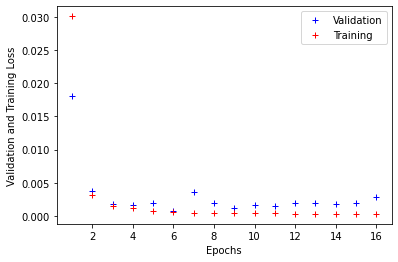

In [ ]:
convHist = conv.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(convHist.epoch)
plotgraphs(convHist, epochs)

This seems to have helped, the model only begins to overtrain at about 6 epochs as opposed to 2. Next lets use dropout, previously shown to be extremley useful in convolutional networks.

In [ ]:
conv = Sequential()
conv.add(Input(shape=(past_days, 2)))
conv.add(Conv1D(filters=32, kernel_size=2 ,activation='relu'))

conv.add(AveragePooling1D(2))
conv.add(Dropout(0.5))
conv.add(LayerNormalization())

conv.add(Conv1D(filters=16, kernel_size=2 , activation='relu'))

conv.add(AveragePooling1D(2))
conv.add(Dropout(0.5))
conv.add(LayerNormalization())
conv.add(Flatten())

conv.add(Dense(1))

conv.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 0.0018722581444308162 / 0.0006102705374360085 respectively and this occurs at epochs 26 / 18 respectively.


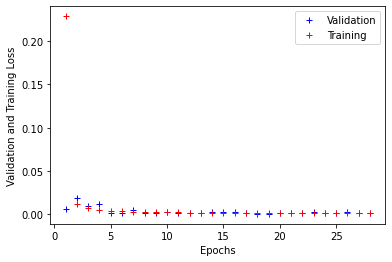

In [ ]:
convHist = conv.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(convHist.epoch)
plotgraphs(convHist, epochs)

Seems good. I wonder whether it is possible to get similar/better results with a lesser value for dropout?

In [ ]:
conv = Sequential()
conv.add(Input(shape=(past_days, 2)))
conv.add(Conv1D(filters=32, kernel_size=2 ,activation='relu'))

conv.add(AveragePooling1D(2))
conv.add(Dropout(0.4))
conv.add(LayerNormalization())

conv.add(Conv1D(filters=16, kernel_size=2 , activation='relu'))

conv.add(AveragePooling1D(2))
conv.add(Dropout(0.4))
conv.add(LayerNormalization())
conv.add(Flatten())

conv.add(Dense(1))

conv.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 0.0017621840815991163 / 0.0007890428532846272 respectively and this occurs at epochs 16 / 6 respectively.


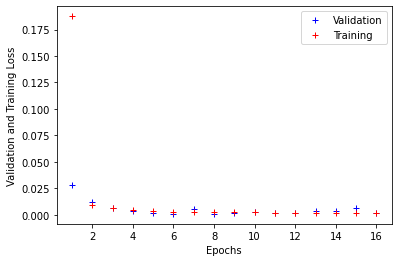

In [ ]:
convHist = conv.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(convHist.epoch)
plotgraphs(convHist, epochs)

This has not worked, higher min val loss and perhaps less generalisation.

Finally, lets try using the wavelet transformed data.


In [ ]:
convw = Sequential()
convw.add(Input(shape=(past_days, 2)))
convw.add(Conv1D(filters=32, kernel_size=2 ,activation='relu'))

convw.add(AveragePooling1D(2))
convw.add(Dropout(0.4))
convw.add(LayerNormalization())

convw.add(Conv1D(filters=16, kernel_size=2 , activation='relu'))

convw.add(AveragePooling1D(2))
convw.add(Dropout(0.4))
convw.add(LayerNormalization())
convw.add(Flatten())

convw.add(Dense(1))

convw.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 0.001753325224854052 / 0.00102496356703341 respectively and this occurs at epochs 17 / 7 respectively.


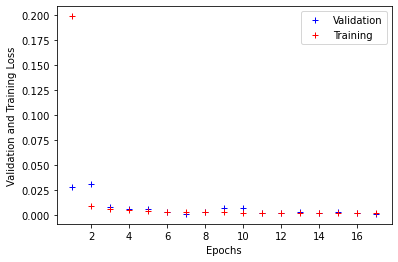

In [ ]:
convwHist = convw.fit(generatortrainwave, validation_data=generatorvalwave, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(convwHist.epoch)
plotgraphs(convwHist, epochs)

No good.

##Two chosen models
These are my two chosen models.

###LSTM

In [ ]:
lchosen = Sequential()
lchosen.add(Input(shape=(past_days, 2)))
lchosen.add(LSTM(units=past_days, return_sequences=True, recurrent_regularizer=regularizers.l1_l2(l1=0, l2=0.0001)))
lchosen.add(LSTM(units=past_days, recurrent_regularizer=regularizers.l1_l2(l1=0, l2=0.0001)))
lchosen.add(Dense(units = 1))

lchosen.compile(optimizer = 'adam', loss = 'mean_squared_error')


Minima of training/validation loss occurs at 0.00012339424574747682 / 7.572583854198456e-05 respectively and this occurs at epochs 18 / 9 respectively.


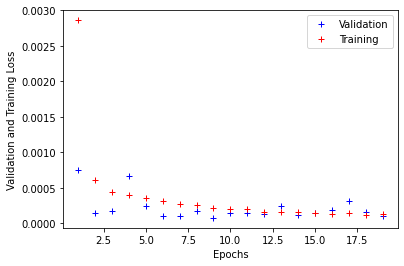

In [ ]:
lchosenHist = lchosen.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(lchosenHist.epoch)
plotgraphs(lchosenHist, epochs)

###CNN

In [ ]:
cchosen = Sequential()
cchosen.add(Input(shape=(past_days, 2)))
cchosen.add(Conv1D(filters=32, kernel_size=2 ,activation='relu'))
 
cchosen.add(AveragePooling1D(2))
cchosen.add(Dropout(0.5))
cchosen.add(LayerNormalization())

cchosen.add(Conv1D(filters=16, kernel_size=2 , activation='relu'))

cchosen.add(AveragePooling1D(2))
cchosen.add(Dropout(0.5))
cchosen.add(LayerNormalization())
cchosen.add(Flatten())

cchosen.add(Dense(1))

cchosen.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 0.002075510798022151 / 0.0005463535198941827 respectively and this occurs at epochs 13 / 4 respectively.


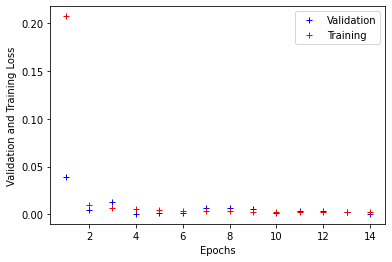

In [ ]:
cchosenHist = cchosen.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(cchosenHist.epoch)
plotgraphs(cchosenHist, epochs)

##Combine the models
Here I will use keras's functional API to combine these two best models. 

In [ ]:
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Activation, Input, BatchNormalization, Embedding, GlobalMaxPooling1D, AveragePooling1D


inputlay = Input(shape=(past_days, 2))

l1 = LSTM(units=past_days, return_sequences=True)(inputlay)
l2 = LSTM(units=past_days)(l1)
l3 = Dense(units = 1)(l2)

c1 = Conv1D(filters=32, kernel_size=2 ,activation='relu')(inputlay)
c2 = AveragePooling1D(2)(c1)
c3 = LayerNormalization()(c2)
c4 = Dropout(0.5)(c3)
c5 = Conv1D(filters=16, kernel_size=2 , activation='relu')(c4)
c6 = AveragePooling1D(2)(c5)
c7 = LayerNormalization()(c6)
c8 = Dropout(0.5)(c7)
c9 = Flatten()(c8)
c10 = Dense(1)(c9)



concat = layers.Concatenate()([c10, l3])
dense = Dense(1)(concat)
merged = Model(inputs=inputlay, outputs=dense)

merged.compile(optimizer = 'adam', loss = 'mean_squared_error')

Minima of training/validation loss occurs at 9.607188258087263e-05 / 4.076885594869964e-06 respectively and this occurs at epochs 26 / 17 respectively.


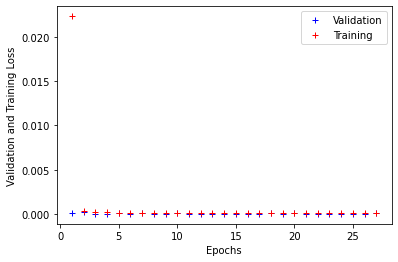

In [ ]:
mergedhist = merged.fit(generatortrain, validation_data=generatorval, epochs = 100, verbose=0, callbacks=earlystop)
epochs=len(mergedhist.epoch)
plotgraphs(mergedhist, epochs)

This is the best model yet. New best minimum validation loss.

##Model Structure

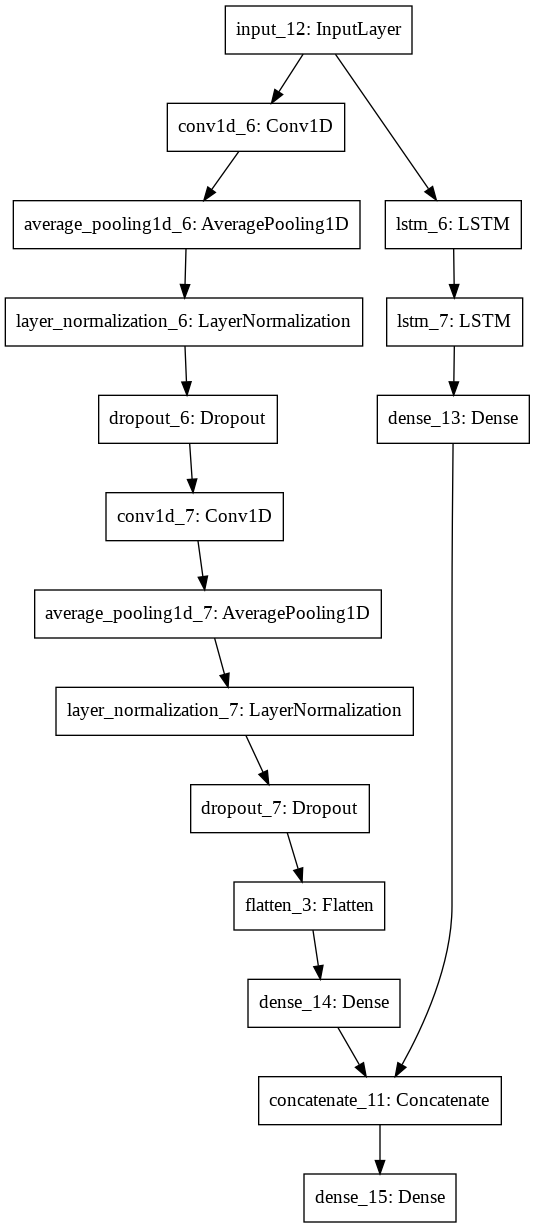

In [ ]:
from keras.utils import plot_model
plot_model(merged)

## Test the model

In [ ]:
import pandas as pd
def invTransform(scaler, data):
    dummy = pd.DataFrame(np.zeros((len(data), 6)))
    dummy[0] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=dummy.columns)
    return dummy[0].values


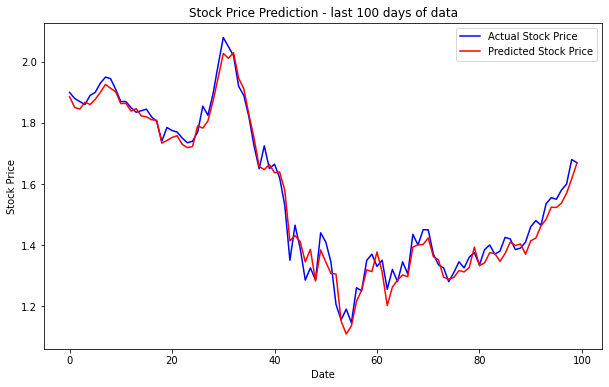

In [ ]:
predictions = merged.predict(generatortest)
predictions = invTransform(scaler, predictions)


plt.figure(figsize=(10,6))
plt.plot(stockdata[-100:,0], color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction - last 100 days of data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()    

## Show the Test performance
### Mean Squared Error

In [ ]:
mean_squared_error(stockdata[-100:,0],predictions)

0.0008946613150305572

In [ ]:
merged.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 60, 2)]      0                                            
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 59, 32)       160         input_12[0][0]                   
__________________________________________________________________________________________________
average_pooling1d_6 (AveragePoo (None, 29, 32)       0           conv1d_6[0][0]                   
__________________________________________________________________________________________________
layer_normalization_6 (LayerNor (None, 29, 32)       64          average_pooling1d_6[0][0]        
______________________________________________________________________________________